# NPZD parameter estimation prototype

 * using a "stochastic" Ensemble Kalman filter

### model code

The cell below contains the model parameters and the NPZD model code, for use with a ordinary differential equation integrator, such as `spipy.integrate.odeint`. Note that the parameter values in `parameters` act as constant reference values or starting point (ensemble mean) for the parameter estimation, depending on whether the parameter in question is being estimated. 

In [1]:
import numpy as np

# parameter values
parameters = {
    'vmax': 0.075,       # maximum growth rate in Michaelis Menten formulation
    'nuthalfsat': 0.3,   # nutrient half saturation in Michaelis Menten formulation
    'graz': 0.02,        # zooplankton grazing rate
    'mortP': 0.02,       # phytoplankton mortality rate
    'mortZ': 0.03,       # zooplankton mortality rate
    'reminrate': 0.1,    # remineralization rate
}

# model code
def npzd(x, t, parameters, light):
    '''
    input
    =====
    x: model state
    t: current time (in days)
    parameters: model parameters
    light: light function returning irradiance at time t
    '''
    n, p, z, d = np.maximum(x, 0.0)
    
    growth = parameters['vmax'] * n / (parameters['nuthalfsat'] + n) * light(t) * p
    grazing = parameters['graz'] * p * z
    p_loss = parameters['mortP'] * p
    z_loss = parameters['mortZ'] * z * z
    remin = parameters['reminrate'] * d
    
    return np.array((-growth+remin, growth-grazing-p_loss, grazing-z_loss, p_loss+z_loss-remin))

### code to run model

Helper functions for computing the light at time t (in units of daya), which is a simple sinusoidal function, and running the NPZD model forward.
The vector `x0`, and the time vector `t` determine the initial conditions and length of each NPZD model simulation.

In [2]:
from scipy.integrate import odeint

# initial conditions
x0 = np.array((0.6, 0.15, 0.2, 0.05))

# initialize time vector (2 years)
t = np.arange(0.0, 2 * 365.0)

# light function returning irradiance at time t
def light(t):
    return 1.0 + 0.5*(0.8 * np.sin(np.pi*((t-81.25)/182.5)) - 0.8)

def run_model(parameter_changes=None):
    parameters_run = parameters.copy()
    if parameter_changes is not None:
        parameters_run.update(parameter_changes)
    return odeint(npzd, x0, t, args=(parameters_run, light))

### settings changeable by the user

Parameters not listed in `parameters_reference` are assumed to be constant and kept at the values specified in `parameters` at the top of the notebook. Currently, the values in `parameters` for parameters that are being estimated, are used as the mean values for the prior ensemble. 

In [3]:
# select which parameters to estimate and what their reference or "true" values should be
parameters_reference = {
    'vmax': 0.06,
    'reminrate': 0.12,
}

# select when to observe state
t_obs = 70 # day 70 (compare plot in NPZD notebook)

# index of the state variables to observe
i_obs = np.array([0, 1, 2]) # N, P, Z

# select the observation uncertainty
obs_uncertainty = np.array([0.0003, 0.0003, 0.0003])

# select the number of ensemble members
n_ens = 50

# select the standard deviation of the prior ensemble for each paramete
prior_uncertainty = np.array([0.01, 0.03])

### code to generate synthetic data and create the ensembles

In [4]:
# number of parameters to estimate
n_par = len(parameters_reference)
# number of observations
n_obs = len(i_obs)

# use model to generate the synthetic data
# true_state is the true model state without any added noise
true_state = run_model(parameter_changes=parameters_reference)[t_obs, i_obs]

# generate ensemble of observations adding pseudo-random noise to true_state
Y = true_state[:,None] + obs_uncertainty[:,None] * np.random.normal(size=(n_obs, n_ens))

# generate the prior ensemble of parameters X by adding pseud-random noise to the parameters 
X_mean = np.array([parameters[p] for p in parameters_reference.keys()])
X = np.maximum(0.0, X_mean[:,None] + prior_uncertainty[:,None] * np.random.normal(size=(n_par, n_ens)))

# for each parameter combination in X, run the NPZD model to generate the prior ensemble of model states HX
HX = np.empty((n_obs, n_ens))
for iens in range(n_ens):
    parameter_changes = {p: v for p, v in zip(parameters_reference.keys(), X[:, iens])}
    HX[:, iens] = run_model(parameter_changes=parameter_changes)[t_obs, i_obs]

### code to perform data assimilation

Run the ensemble Kalman filter. Below, the symbold denote:

`HBHT`: $\mathbf{H}\mathbf{B}\mathbf{H}^T$

`BHT`: $\mathbf{B}\mathbf{H}^T$

`R`: $\mathbf{R}$

`K`: $\mathbf{B}\mathbf{H}^T \left(\mathbf{H}\mathbf{B}\mathbf{H}^T + \mathbf{R}\right)$ (Kalman gain)



In [5]:
HBHT = np.cov(HX)
BHT = np.cov(X, HX)[:n_par,-n_obs:]
R = np.diag(obs_uncertainty)

K = BHT @ np.linalg.inv(HBHT + R)

# use kalman gain to compute update for each ensemble member in X, and store updated ensemble in X_post
X_post = np.empty_like(X)
for iens in range(n_ens):
    X_post[:, iens] = X[:, iens] + K @ (Y[:,iens] - HX[:,iens])

# one-line version
#X_post = X + np.array([K @ (y - Hx) for y, Hx in zip(Y.T, HX.T)]).T

### prepare plotting

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Ellipse
from math import atan2

mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (16, 9)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['font.size'] = 20


#matplotlib.patches.Ellipse(xy, width, height, angle=0

def draw_ellipse(ax, cov=None, xy=None, ensemble=None, **plotargs):
    if ensemble is not None:
        xy = np.mean(ensemble, axis=1)
        cov = np.cov(ensemble)

    assert cov.shape == (2, 2), 'Covariance matrix must be 2 x 2.'

    a = cov[0, 0]
    b = cov[1, 0]
    c = cov[1, 1]

    tmp = np.sqrt((0.5 * (a - c))**2 + b**2)
    l1 = 0.5 * (a + c) + tmp
    l2 = 0.5 * (a + c) - tmp

    if b == 0 and a >= c:
        angle = 0
    elif b == 0 and a < c:
        angle = 90
    else:
        angle = atan2(l1 - a, b) * 180 / np.pi

    e = Ellipse(xy, width=np.sqrt(l1), height=np.sqrt(l2), angle=angle, **plotargs)

    ax.add_artist(e)


def draw_ensemble(ax, ensemble, color=None, label=None):
    ax.plot(ensemble[0, :], ensemble[1, :], ls='none', marker='o', color=color, alpha=0.5, mec='none', label=label)
    draw_ellipse(ax, ensemble=ensemble, color=color, alpha=0.2, zorder=0.2)
    ax.plot(np.mean(ensemble[0, :]), np.mean(ensemble[1, :]), ls='none', marker='+', mew=3, color=color, ms=15)

### plotting

Plot the ensemble and associated normal distribution (mean and covariance ellipse) before and after assimilation.

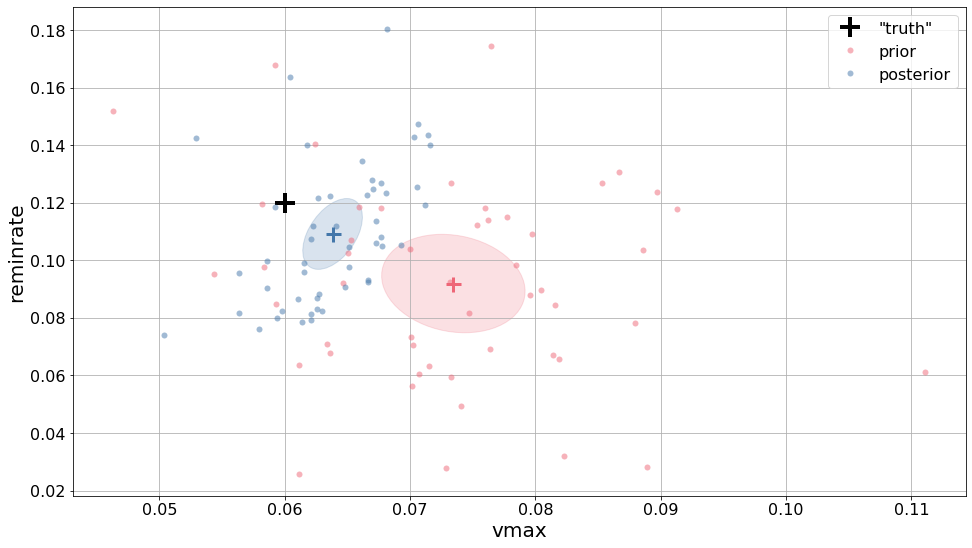

In [7]:
fig, ax = plt.subplots()

ref = np.array([v for v in parameters_reference.values()])
ax.plot(ref[0], ref[1], ls='none', marker='+', mew=4, color='black', ms=20, label='"truth"')

# colors = ('#228833', '#4477AA', '#EE6677', '#CCBB44') # colorblind-friendly colors

draw_ensemble(ax, X, color='#EE6677', label='prior ensemble')
draw_ensemble(ax, X_post, color='#4477AA', label='posterior ensemble')

parameter_names = list(parameters_reference.keys())
ax.set(xlabel=parameter_names[0], ylabel=parameter_names[1])
ax.legend()
ax.grid(True)
None